(parameters_recovery)=
# Parameters recovery, prior predictive and posterior predictive sampling

In [1]:
from numpy import loadtxt
import numpy as np
from ghgf.distribution import hgf_logp, HGFDistribution
from ghgf import load_data
from ghgf.response import total_binary_surprise
import jax.numpy as jnp
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

np.random.seed(123)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In this tutorial, we are going to demonstrate some forms of parameters recovery, prior predictive and posterior predictive sampling that can be a way to assess the strength of the model fitting.

## Continuous HGF
### Simulate a dataset

In [2]:
n_data = 6
dataset = []
for participant in range(n_data):
    input_data = []
    kappa_1 = 1.0
    omega_1 = -10.0
    omega_2 = -10.0
    mu_1 = 0.0
    mu_2 = 0.0
    pi_1 = 1e4
    pi_2 = 1e1
    
    # two-level hierarchical gaussian random walk
    for i in range(1000):
        
        # x2
        pi_2 = np.exp(omega_2)
        mu_2 = np.random.normal(mu_2, pi_2**.5)

        # x1
        pi_1 = np.exp(kappa_1 * mu_2 + omega_1)
        mu_1 = np.random.normal(mu_1, pi_1**.5)
        
        # input node
        u = np.random.normal(mu_1, 1e-4**.5)
        input_data.append(u)

    dataset.append(input_data)

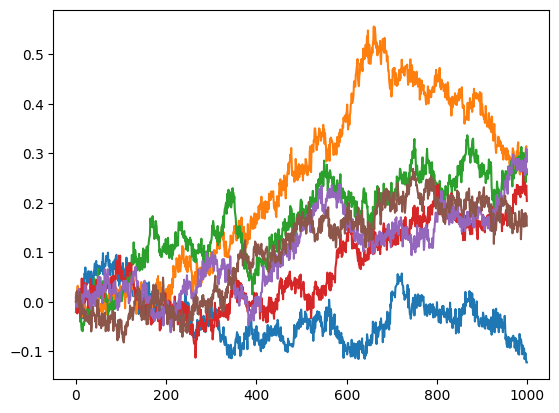

In [3]:
for rw in dataset:
    plt.plot(rw)

## Embedding a serie of HGFs in a graphical model

Here, we are goingin to estimate the parameter $omega_{1}$ from the time series created by the hierarchical random walks. All the time series were generated using $omega_{1} = -10.0$ and we want to see how the Bayesian inference can retrieve these values.

In [4]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="continuous",
    input_data=dataset,
)

In [5]:
with pm.Model() as model:
    
    # Priors
    #-------
    omega_1 = pm.Normal("omega_1", mu=0.0, sigma=2.0, shape=n_data)

    pm.Potential(
        "hgf_loglike",
        hgf_logp_op(
            omega_1=omega_1,
            omega_2=-10.0,
            omega_input=np.log(1e-4),
            rho_1=0.0,
            rho_2=0.0,
            pi_1=1e4,
            pi_2=1e1,
            mu_1=0.0,
            mu_2=0.0,
            kappa_1=1.0,
            omega_3=jnp.nan,
            rho_3=jnp.nan,
            pi_3=jnp.nan,
            mu_3=jnp.nan,
            kappa_2=jnp.nan
        ),
    )

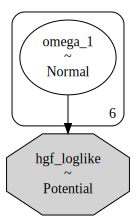

In [6]:
pm.model_to_graphviz(model)

In [7]:
with model:
    idata = pm.sample(chains=4, cores=4, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


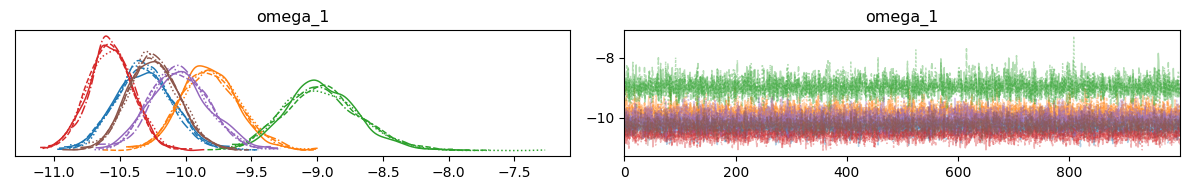

In [8]:
az.plot_trace(idata);
plt.tight_layout()

In [9]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega_1[0],-10.312,0.217,-10.722,-9.926,0.003,0.002,5897.0,3216.0,1.0
omega_1[1],-9.813,0.221,-10.214,-9.384,0.003,0.002,6435.0,3248.0,1.0
omega_1[2],-8.962,0.287,-9.478,-8.417,0.004,0.003,6445.0,3047.0,1.0
omega_1[3],-10.570,0.170,-10.875,-10.233,0.002,0.002,5201.0,3427.0,1.0
omega_1[4],-10.043,0.224,-10.458,-9.627,0.003,0.002,6186.0,3291.0,1.0
omega_1[5],-10.242,0.191,-10.586,-9.874,0.002,0.002,6223.0,3179.0,1.0


## Binary HGF

### Simulate a dataset

In [10]:
n_data = 10
dataset = []
for participant in range(n_data):
    input_data = []
    omega_2 = -1.0
    mu_2 = -1.0

    for i in range(1000):
        
        # x2
        pi_2 = np.exp(omega_2)
        mu_2 = np.random.normal(mu_2, pi_2**.5)

        # x1
        s2 = 1/(1+np.exp(-mu_2))  # sigmoid function
        u = np.random.binomial(n=1, p=s2)       
        input_data.append(u)

    dataset.append(input_data)

### Bayesian inference

In [11]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="binary",
    input_data=dataset,
    response_function=total_binary_surprise,
)

In [12]:
with pm.Model() as two_levels_binary_hgf:

    omega_2 = pm.Uniform("omega_2", -5.0, 0.0, shape=n_data)

    pm.Potential(
        "hgf_loglike",
        hgf_logp_op(
            omega_1=jnp.nan,
            omega_2=omega_2,
            omega_input=jnp.nan,
            rho_1=0.0,
            rho_2=0.0,
            pi_1=0.0,
            pi_2=1e4,
            mu_1=jnp.nan,
            mu_2=0.0,
            kappa_1=1.0,
            omega_3=jnp.nan,
            rho_3=jnp.nan,
            pi_3=jnp.nan,
            mu_3=jnp.nan,
            kappa_2=jnp.nan
        ),
    )

#### Visualizing the model

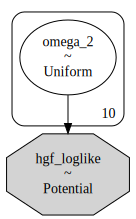

In [13]:
pm.model_to_graphviz(two_levels_binary_hgf)

#### Sampling

In [14]:
with two_levels_binary_hgf:
    two_level_hgf_idata = pm.sample(chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


TypeError: scan carry output and input must have identical types, got
(({'eta0': 'ShapedArray(float32[], weak_type=True)', 'eta1': 'ShapedArray(float32[], weak_type=True)', 'pihat': 'ShapedArray(float32[], weak_type=True)'}, (({'kappas': ('ShapedArray(float32[])',), 'mu': 'ShapedArray(float32[])', 'muhat': 'ShapedArray(float32[])', 'nu': 'ShapedArray(float32[], weak_type=True)', 'omega': 'ShapedArray(float32[])', 'pi': 'ShapedArray(float32[])', 'pihat': 'ShapedArray(float32[])', 'psis': None, 'rho': 'ShapedArray(float32[])'}, (({'kappas': None, 'mu': 'ShapedArray(float32[])', 'muhat': 'ShapedArray(float32[])', 'nu': 'ShapedArray(float32[])', 'omega': 'ShapedArray(float32[])', 'pi': 'ShapedArray(float32[])', 'pihat': 'ShapedArray(float32[])', 'psis': None, 'rho': 'ShapedArray(float32[])'}, None, None),), None),), None), {'surprise': 'ShapedArray(float32[])', 'time': 'ShapedArray(float32[])', 'value': 'DIFFERENT ShapedArray(float32[]) vs. ShapedArray(int32[])'}).
Apply node that caused the error: HGFDistribution(TensorConstant{nan}, omega_2, TensorConstant{nan}, TensorConstant{nan}, TensorConstant{0.0}, TensorConstant{0.0}, TensorConstant{nan}, TensorConstant{0.0}, TensorConstant{10000.0}, TensorConstant{nan}, TensorConstant{nan}, TensorConstant{0.0}, TensorConstant{nan}, TensorConstant{1.0}, TensorConstant{nan})
Toposort index: 1
Inputs types: [TensorType(float64, ()), TensorType(float64, (10,)), TensorType(float64, ()), TensorType(float64, ()), TensorType(float32, ()), TensorType(float32, ()), TensorType(float64, ()), TensorType(float32, ()), TensorType(float32, ()), TensorType(float64, ()), TensorType(float64, ()), TensorType(float32, ()), TensorType(float64, ()), TensorType(float32, ()), TensorType(float64, ())]
Inputs shapes: [(), (10,), (), (), (), (), (), (), (), (), (), (), (), (), ()]
Inputs strides: [(), (8,), (), (), (), (), (), (), (), (), (), (), (), (), ()]
Inputs values: [array(nan), 'not shown', array(nan), array(nan), array(0., dtype=float32), array(0., dtype=float32), array(nan), array(0., dtype=float32), array(10000., dtype=float32), array(nan), array(nan), array(0., dtype=float32), array(nan), array(1., dtype=float32), array(nan)]
Outputs clients: [['output']]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
    return runner(coro)
  File "/opt/anaconda3/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3699175/2414223990.py", line 7, in <cell line: 1>
    hgf_logp_op(
  File "/opt/anaconda3/lib/python3.8/site-packages/pytensor/graph/op.py", line 296, in __call__
    node = self.make_node(*inputs, **kwargs)
  File "/home/nicolas/git/ghgf/ghgf/distribution.py", line 515, in make_node
    outputs = [pt.dscalar()]

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [ ]:
az.plot_trace(two_level_hgf_idata);
plt.tight_layout()

In [ ]:
az.summary(two_level_hgf_idata)